## Example of python program converting a raw CSV file to a DataFrame and then exporting to a PostgresSQL table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import dependencies
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
from sqlalchemy import create_engine
import psycopg2 
import psycopg2.extras
import io
import getpass
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from imblearn.ensemble import BalancedRandomForestClassifier

In [3]:
try:
    p = getpass.getpass()
except Exception as error:
    print('ERROR', error)

········


In [4]:
engine = create_engine('postgresql://postgres:' + p + '@localhost:5432/WTA')

# Example python program to read data from a PostgreSQL table and load into a pandas DataFrame

In [5]:
# Connect to PostgreSQL server
dbConnection = engine.connect()

In [6]:
# Read data from PostgreSQL database table and load into a DataFrame instance
dataFrame = pd.read_sql("select * from \"matches\"", dbConnection)

In [7]:
# Print the DataFrame
dataFrame.head()

,index,tourney_date,tourney_name,tourney_level,surface,rounds,best_of,winner_id,winner_name,winner_rank,loser_id,loser_name,loser_rank
0,0,20100206,Fed Cup WG R1: UKR vs ITA,D,Hard,RR,3,201416,Alona Bondarenko,26.0,201212,Francesca Schiavone,18.0
1,1,20100206,Fed Cup WG R1: UKR vs ITA,D,Hard,RR,3,201355,Flavia Pennetta,12.0,201435,Kateryna Bondarenko,33.0
2,2,20100206,Fed Cup WG R1: UKR vs ITA,D,Hard,RR,3,201355,Flavia Pennetta,12.0,201416,Alona Bondarenko,26.0
3,3,20100206,Fed Cup WG R1: UKR vs ITA,D,Hard,RR,3,201212,Francesca Schiavone,18.0,201435,Kateryna Bondarenko,33.0
4,4,20100206,Fed Cup WG R1: CZE vs GER,D,Hard,RR,3,201394,Anna Lena Groenefeld,66.0,201425,Lucie Safarova,46.0


In [8]:
# Close the database connection
dbConnection.close();

## Example of pre-processing data before plugging it on a Machine Learning model

In [9]:
dataFrame.shape

(22309, 13)

In [10]:
dataFrame.dtypes

index              int64
tourney_date       int64
tourney_name      object
tourney_level     object
surface           object
rounds            object
best_of            int64
winner_id          int64
winner_name       object
winner_rank      float64
loser_id           int64
loser_name        object
loser_rank       float64
dtype: object

In [11]:
# Converting tourney_date to datetime format
dataFrame['tourney_date'] = pd.to_datetime(dataFrame['tourney_date'], format='%Y%m%d') 
# Choosing features
cols_to_keep = ['tourney_date','tourney_name','surface', 'rounds', 'winner_rank','loser_rank']
# Dropping NaN
dataFrame = dataFrame[cols_to_keep].dropna()
# Dropping errors in the dataset 
dataFrame = dataFrame[(dataFrame['loser_rank'] != 'NR') & (dataFrame['winner_rank'] != 'NR')]
dataFrame.head()

,tourney_date,tourney_name,surface,rounds,winner_rank,loser_rank
0,2010-02-06,Fed Cup WG R1: UKR vs ITA,Hard,RR,26.0,18.0
1,2010-02-06,Fed Cup WG R1: UKR vs ITA,Hard,RR,12.0,33.0
2,2010-02-06,Fed Cup WG R1: UKR vs ITA,Hard,RR,12.0,26.0
3,2010-02-06,Fed Cup WG R1: UKR vs ITA,Hard,RR,18.0,33.0
4,2010-02-06,Fed Cup WG R1: CZE vs GER,Hard,RR,66.0,46.0


In [12]:
dataFrame.shape

(22306, 6)

In [13]:
dataFrame.dtypes

tourney_date    datetime64[ns]
tourney_name            object
surface                 object
rounds                  object
winner_rank            float64
loser_rank             float64
dtype: object

In [14]:
# Transform strings into numerical values
dataFrame[['winner_rank','loser_rank']] = dataFrame[['winner_rank','loser_rank']].astype(int)
dataFrame.head()

,tourney_date,tourney_name,surface,rounds,winner_rank,loser_rank
0,2010-02-06,Fed Cup WG R1: UKR vs ITA,Hard,RR,26,18
1,2010-02-06,Fed Cup WG R1: UKR vs ITA,Hard,RR,12,33
2,2010-02-06,Fed Cup WG R1: UKR vs ITA,Hard,RR,12,26
3,2010-02-06,Fed Cup WG R1: UKR vs ITA,Hard,RR,18,33
4,2010-02-06,Fed Cup WG R1: CZE vs GER,Hard,RR,66,46


In [15]:
dataFrame.dtypes

tourney_date    datetime64[ns]
tourney_name            object
surface                 object
rounds                  object
winner_rank              int32
loser_rank               int32
dtype: object

In [16]:
# Create an extra columns for the variable win described above using an auxiliary function win(x)
def win(x):
    if x > 0:
        return 0
    elif x <= 0:
        return 1  
    
dataFrame['win'] = (dataFrame['winner_rank'] - dataFrame['loser_rank']).apply(win)
dataFrame.head()

,tourney_date,tourney_name,surface,rounds,winner_rank,loser_rank,win
0,2010-02-06,Fed Cup WG R1: UKR vs ITA,Hard,RR,26,18,0
1,2010-02-06,Fed Cup WG R1: UKR vs ITA,Hard,RR,12,33,1
2,2010-02-06,Fed Cup WG R1: UKR vs ITA,Hard,RR,12,26,1
3,2010-02-06,Fed Cup WG R1: UKR vs ITA,Hard,RR,18,33,1
4,2010-02-06,Fed Cup WG R1: CZE vs GER,Hard,RR,66,46,0


In [17]:
# Check win frequency

print(dataFrame['win'].sum(axis=0))
print(len(dataFrame.index))
dataFrame['win'].sum(axis=0)/float(len(dataFrame.index))

14196
22306


0.6364206939836815

In [18]:
# yo correct our uneven win frequency we use Stratified sampling 
y_0 = dataFrame[dataFrame.win == 0] 
y_1 = dataFrame[dataFrame.win == 1] 
n = min([len(y_0), len(y_1)]) 
y_0 = y_0.sample(n = n, random_state = 0) 
y_1 = y_1.sample(n = n, random_state = 0)
df_strat = pd.concat([y_0, y_1]) 
X_strat = df_strat[['tourney_date','tourney_name','surface', 'rounds', 'winner_rank','loser_rank']]
y_strat = df_strat.win

In [19]:
X_strat.head()

,tourney_date,tourney_name,surface,rounds,winner_rank,loser_rank
12962,2016-05-16,Strasbourg,Clay,R16,66,44
5225,2012-05-07,Madrid,Clay,R32,41,19
14741,2016-10-17,Moscow,Hard,R32,47,44
15027,2016-08-08,Olympics,Hard,R16,34,4
696,2010-07-19,Portoroz,Hard,R16,129,2


In [20]:
y_strat.head()

12962    0
5225     0
14741    0
15027    0
696      0
Name: win, dtype: int64

In [21]:
X_strat_1=X_strat.copy()
X_strat_1['win']=y_strat
X_strat_1.head()

,tourney_date,tourney_name,surface,rounds,winner_rank,loser_rank,win
12962,2016-05-16,Strasbourg,Clay,R16,66,44,0
5225,2012-05-07,Madrid,Clay,R32,41,19,0
14741,2016-10-17,Moscow,Hard,R32,47,44,0
15027,2016-08-08,Olympics,Hard,R16,34,4,0
696,2010-07-19,Portoroz,Hard,R16,129,2,0


In [22]:
# define the variables ${\cal P}_1$ and ${\cal P}_2$ where ${{\rm Rank}_1} &gt; {{\rm Rank}_2}$
df0 = X_strat_1.copy()
df0["P1"] = df0[["winner_rank", "loser_rank"]].max(axis=1)
df0["P2"] = df0[["winner_rank", "loser_rank"]].min(axis=1)
df0.head()

,tourney_date,tourney_name,surface,rounds,winner_rank,loser_rank,win,P1,P2
12962,2016-05-16,Strasbourg,Clay,R16,66,44,0,66,44
5225,2012-05-07,Madrid,Clay,R32,41,19,0,41,19
14741,2016-10-17,Moscow,Hard,R32,47,44,0,47,44
15027,2016-08-08,Olympics,Hard,R16,34,4,0,34,4
696,2010-07-19,Portoroz,Hard,R16,129,2,0,129,2


### Exploratory Analysis for the DataFrame

In [23]:
print(dataFrame['surface'].unique())

['Hard' 'Clay' 'Carpet' 'Grass']


In [24]:
# Look at percentage of wins for each surface. 
win_by_Surface = pd.crosstab(dataFrame.win, dataFrame.surface).apply( lambda x: x/x.sum(), axis = 0 )
win_by_Surface

surface,Carpet,Clay,Grass,Hard
win,,,,
0,0.326087,0.375833,0.365225,0.358697
1,0.673913,0.624167,0.634775,0.641303


In [25]:
print(dataFrame['rounds'].unique())

['RR' 'QF' 'SF' 'F' 'R32' 'R16' 'R64' 'R128' 'BR']


In [26]:
# Look at percentage of wins for each round.
win_by_round = pd.crosstab(dataFrame.win, dataFrame['rounds']).apply( lambda x: x/x.sum(), axis = 0 )
win_by_round

rounds,BR,F,QF,R128,R16,R32,R64,RR,SF
win,,,,,,,,,
0,1.0,0.397924,0.377127,0.337172,0.377783,0.363873,0.354203,0.348451,0.378947
1,0.0,0.602076,0.622873,0.662828,0.622217,0.636127,0.645797,0.651549,0.621053


#### Dummy variables

In [27]:
df = dataFrame[(dataFrame['rounds'] != 'BR') & (dataFrame['rounds'] != 'RR') ]
df.head()

,tourney_date,tourney_name,surface,rounds,winner_rank,loser_rank,win
86,2010-11-01,Tournament of Champions,Hard,QF,53,11,0
87,2010-11-01,Tournament of Champions,Hard,QF,24,20,0
88,2010-11-01,Tournament of Champions,Hard,QF,31,22,0
89,2010-11-01,Tournament of Champions,Hard,QF,27,18,0
90,2010-11-01,Tournament of Champions,Hard,SF,24,53,1


In [28]:
df1 = df.copy()
dummy_ranks = pd.get_dummies(df1['rounds'])
dummy_ranks.head()

,F,QF,R128,R16,R32,R64,SF
86,0,1,0,0,0,0,0
87,0,1,0,0,0,0,0
88,0,1,0,0,0,0,0
89,0,1,0,0,0,0,0
90,0,0,0,0,0,0,1


In [29]:
# To keep the dataframe cleaner, we transform the Round entries into numbers. We then transform rounds into dummy variables
def round_convert(x):
    if x == 'R128':
        return 1
    elif x == 'R64':
        return 2
    elif x == 'R32':
        return 3
    elif x == 'R16':
        return 4
    elif x == 'QF':
        return 5
    elif x == 'SF':
        return 6
    elif x == 'F':
        return 7
    
df1['rounds'] = df1['rounds'].apply(round_convert)
df1['rounds'].head()

86    5
87    5
88    5
89    5
90    6
Name: rounds, dtype: int64

In [30]:
df_rounds = df1.join(dummy_ranks)
df_rounds

,tourney_date,tourney_name,surface,rounds,winner_rank,loser_rank,win,F,QF,R128,R16,R32,R64,SF
86,2010-11-01,Tournament of Champions,Hard,5,53,11,0,0,1,0,0,0,0,0
87,2010-11-01,Tournament of Champions,Hard,5,24,20,0,0,1,0,0,0,0,0
88,2010-11-01,Tournament of Champions,Hard,5,31,22,0,0,1,0,0,0,0,0
89,2010-11-01,Tournament of Champions,Hard,5,27,18,0,0,1,0,0,0,0,0
90,2010-11-01,Tournament of Champions,Hard,6,24,53,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22281,2020-11-09,Linz,Hard,3,75,65,0,0,0,0,0,1,0,0
22282,2020-11-09,Linz,Hard,3,95,118,1,0,0,0,0,1,0,0
22283,2020-11-09,Linz,Hard,3,33,64,1,0,0,0,0,1,0,0
22284,2020-11-09,Linz,Hard,3,46,148,1,0,0,0,0,1,0,0


In [31]:
dummy_ranks = pd.get_dummies(df1['surface'], prefix='surface')
dummy_ranks.sample(10)

,surface_Carpet,surface_Clay,surface_Grass,surface_Hard
7812,0,1,0,0
9950,0,1,0,0
6978,0,0,0,1
13309,0,0,0,1
8295,0,1,0,0
4780,0,0,0,1
1680,0,0,0,1
15362,0,1,0,0
9439,0,1,0,0
1254,0,0,1,0


In [32]:
df_2 = df_rounds.join(dummy_ranks)
df_2.drop("surface",axis = 1,inplace=True)
df_2[['surface_Grass','surface_Hard']] = df_2[['surface_Grass','surface_Hard']].astype('int_')
df_2.drop("rounds",axis = 1,inplace=True)
df_2.head()

,tourney_date,tourney_name,winner_rank,loser_rank,win,F,QF,R128,R16,R32,R64,SF,surface_Carpet,surface_Clay,surface_Grass,surface_Hard
86,2010-11-01,Tournament of Champions,53,11,0,0,1,0,0,0,0,0,0,0,0,1
87,2010-11-01,Tournament of Champions,24,20,0,0,1,0,0,0,0,0,0,0,0,1
88,2010-11-01,Tournament of Champions,31,22,0,0,1,0,0,0,0,0,0,0,0,1
89,2010-11-01,Tournament of Champions,27,18,0,0,1,0,0,0,0,0,0,0,0,1
90,2010-11-01,Tournament of Champions,24,53,1,0,0,0,0,0,0,1,0,0,0,1


In [33]:
# We now take the logarithms of ${\cal P}_1$ and ${\cal P}_2$, then create a variable D
df4 = df_2.copy()
df4['winner_rank'] = np.log2(df4['winner_rank'].astype('float64')) 
df4['loser_rank'] = np.log2(df4['loser_rank'].astype('float64')) 
df4['D'] = df4['winner_rank'] - df4['loser_rank']
df4['D'] = np.absolute(df4['D'])
df4.head()

,tourney_date,tourney_name,winner_rank,loser_rank,win,F,QF,R128,R16,R32,R64,SF,surface_Carpet,surface_Clay,surface_Grass,surface_Hard,D
86,2010-11-01,Tournament of Champions,5.727920,3.459432,0,0,1,0,0,0,0,0,0,0,0,1,2.268489
87,2010-11-01,Tournament of Champions,4.584963,4.321928,0,0,1,0,0,0,0,0,0,0,0,1,0.263034
88,2010-11-01,Tournament of Champions,4.954196,4.459432,0,0,1,0,0,0,0,0,0,0,0,1,0.494765
89,2010-11-01,Tournament of Champions,4.754888,4.169925,0,0,1,0,0,0,0,0,0,0,0,1,0.584963
90,2010-11-01,Tournament of Champions,4.584963,5.727920,1,0,0,0,0,0,0,1,0,0,0,1,1.142958


### Logistic Regression

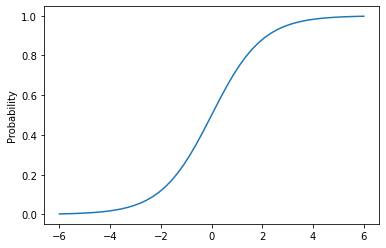

In [34]:
import numpy as np
import matplotlib.pyplot as plt
# Logit Function
def logit(x):
    return np.exp(x)  / (1 + np.exp(x)) 
    
x = np.linspace(-6,6,50, dtype=float)

y = logit(x)

plt.plot(x, y)
plt.ylabel("Probability")
plt.show()

In [35]:
df4.columns.tolist()

['tourney_date',
 'tourney_name',
 'winner_rank',
 'loser_rank',
 'win',
 'F',
 'QF',
 'R128',
 'R16',
 'R32',
 'R64',
 'SF',
 'surface_Carpet',
 'surface_Clay',
 'surface_Grass',
 'surface_Hard',
 'D']

In [36]:
df4.head()

,tourney_date,tourney_name,winner_rank,loser_rank,win,F,QF,R128,R16,R32,R64,SF,surface_Carpet,surface_Clay,surface_Grass,surface_Hard,D
86,2010-11-01,Tournament of Champions,5.727920,3.459432,0,0,1,0,0,0,0,0,0,0,0,1,2.268489
87,2010-11-01,Tournament of Champions,4.584963,4.321928,0,0,1,0,0,0,0,0,0,0,0,1,0.263034
88,2010-11-01,Tournament of Champions,4.954196,4.459432,0,0,1,0,0,0,0,0,0,0,0,1,0.494765
89,2010-11-01,Tournament of Champions,4.754888,4.169925,0,0,1,0,0,0,0,0,0,0,0,1,0.584963
90,2010-11-01,Tournament of Champions,4.584963,5.727920,1,0,0,0,0,0,0,1,0,0,0,1,1.142958


In [37]:
cols_to_keep = ['F', 'QF', 'R128', 'R16', 'R32', 'R64', 'SF', 'D', 'surface_Clay', 'surface_Clay', 'surface_Grass']
# Dropping NaN
X = df4[cols_to_keep].dropna()
X.head()

,F,QF,R128,R16,R32,R64,SF,D,surface_Clay,surface_Clay,surface_Grass
86,0,1,0,0,0,0,0,2.268489,0,0,0
87,0,1,0,0,0,0,0,0.263034,0,0,0
88,0,1,0,0,0,0,0,0.494765,0,0,0
89,0,1,0,0,0,0,0,0.584963,0,0,0
90,0,0,0,0,0,0,1,1.142958,0,0,0


In [38]:
# Separate the Features (X) from the Target (y)
y = df4["win"]

In [39]:
# Split our data into training and testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1, 
                                                    stratify=y)
X_train.shape

(16050, 11)

In [40]:
# Create a Logistic Regression Model
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver='lbfgs',
                                max_iter=200,
                                random_state=1)

In [41]:
# Fit (train) or model using the training data
classifier.fit(X_train, y_train)

LogisticRegression(max_iter=200, random_state=1)

In [42]:
# Make predictions
y_pred = classifier.predict(X_test)
results = pd.DataFrame({"Prediction": y_pred, "Actual": y_test}).reset_index(drop=True)
results.head(20)

,Prediction,Actual
0,1,1
1,1,0
2,1,0
3,1,1
4,1,1
5,1,1
6,1,0
7,1,1
8,1,1
9,1,1


In [43]:
# Print the accuracy
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.6350214913100355


In [44]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[  57, 1892],
       [  61, 3341]], dtype=int64)

In [45]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.48      0.03      0.98      0.06      0.17      0.03      1949
          1       0.64      0.98      0.03      0.77      0.17      0.03      3402

avg / total       0.58      0.64      0.38      0.51      0.17      0.03      5351



In [46]:
# features sorted in descending order by feature importance
brfc = BalancedRandomForestClassifier(random_state=1, n_estimators=100)
brfc.fit(X_train, y_train)
features_importance = brfc.feature_importances_
features = sorted(zip(X.columns, features_importance), reverse=True, key = lambda x: x[1])
features

[('D', 0.9807006163800445),
 ('surface_Grass', 0.004605260547200342),
 ('R128', 0.0023384506259240966),
 ('R16', 0.0019427289590073804),
 ('R32', 0.0017643446339151727),
 ('R64', 0.0017150337397532666),
 ('SF', 0.0015565891114813117),
 ('QF', 0.0015219592010224513),
 ('F', 0.0013453348546960176),
 ('surface_Clay', 0.001256887187732227),
 ('surface_Clay', 0.0012527947592233036)]

In [50]:
from sklearn import metrics

In [51]:
y_pred_prob = classifier.predict_proba(X_test)[:, 1]
auc_score = metrics.roc_auc_score(y_test, y_pred_prob)
auc_score

0.5976974127735202

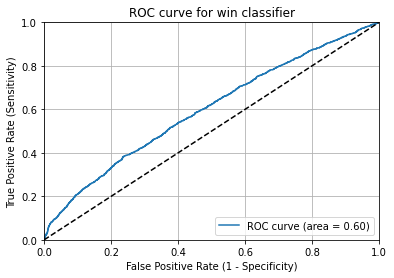

In [54]:
# Create ROC curve
y_pred_prob = classifier.predict_proba(X_test)[:, 1]
auc_score = metrics.roc_auc_score(y_test, y_pred_prob)
auc_score
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
fig = plt.plot(fpr, tpr,label='ROC curve (area = %0.2f)' % auc_score )
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for win classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)


### Random Forrest

In [55]:
# Resample the training data with the BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
brfc = BalancedRandomForestClassifier(random_state=1, n_estimators=100)
brfc.fit(X_train, y_train)

BalancedRandomForestClassifier(random_state=1)

In [57]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score
y_predict = brfc.predict(X_test)
bas = balanced_accuracy_score(y_test, y_predict)
bas

0.5136686565624482

In [58]:
# Display the confusion matrix
confusion_matrix(y_test, y_predict)

array([[1002,  947],
       [1656, 1746]], dtype=int64)

In [59]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_predict))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.38      0.51      0.51      0.43      0.51      0.26      1949
          1       0.65      0.51      0.51      0.57      0.51      0.26      3402

avg / total       0.55      0.51      0.51      0.52      0.51      0.26      5351



In [60]:
# List the features sorted in descending order by feature importance
features_importance = brfc.feature_importances_
features = sorted(zip(X.columns, features_importance), reverse=True, key = lambda x: x[1])
features

[('D', 0.9807006163800445),
 ('surface_Grass', 0.004605260547200342),
 ('R128', 0.0023384506259240966),
 ('R16', 0.0019427289590073804),
 ('R32', 0.0017643446339151727),
 ('R64', 0.0017150337397532666),
 ('SF', 0.0015565891114813117),
 ('QF', 0.0015219592010224513),
 ('F', 0.0013453348546960176),
 ('surface_Clay', 0.001256887187732227),
 ('surface_Clay', 0.0012527947592233036)]